# Using Tractor catalog for positions

In [11]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.utils import data as data_utils
from astropy.nddata import bitmask

from scipy.ndimage import distance_transform_edt

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

# import json
# import requests
from dl import authClient as ac, queryClient as qc
import pandas as pd

## Image query

In [2]:
def query_tractor(ra_b, dec_b, dist):
    """Queries the Astro Data Lab for the ra, dec and mag_g of the objects within a square of side length (dist).     
    dist is in degrees
    """
    #Bounds of the square we are querying objects for
    ra_min=ra_b
    ra_max = ra_b + dist
    dec_min=dec_b
    dec_max = dec_b + dist

    query = f"""
    SELECT ra, dec, mag_g
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_g <= 21 AND mag_g >= 16
    """
    
    print("Querying the Astro Data Lab...")
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    return brick_info

tractor_df = query_tractor(0, 0, 1.0)

Querying the Astro Data Lab...


In [3]:
ra = tractor_df['ra']
dec = tractor_df['dec']

## Get bitmask info

In [4]:
# there will be a text file to read from at some point lol

## Segmentation map

Start with OG seg map, without bitmask stuff yet

In [16]:
# creating seg map by pixels

dim = 3600*4
array = np.zeros((dim, dim), dtype=int)
ra_pix = (np.round(ra*dim)).values - 1
dec_pix = (np.round(dec*dim)).values - 1

for x, y in zip(ra_pix,dec_pix):
    array[int(x)][int(y)] = 1

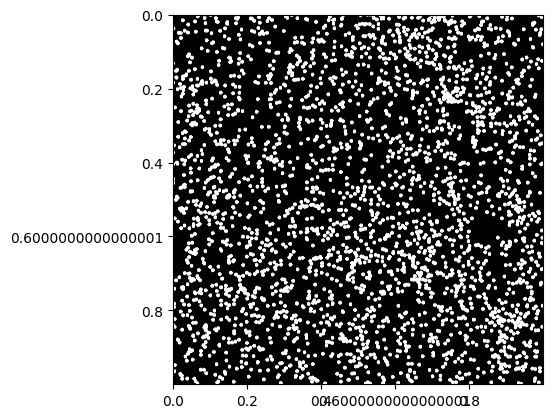

In [21]:
distance = distance_transform_edt(array == 0,sampling=0.262)

excl_map = np.copy(array)
excl_map[distance <= 20] = 1

positions = np.linspace(0,dim,6)
labels = np.linspace(0,1,6)

plt.xticks(positions, labels)
plt.yticks(positions, labels)
plt.imshow(excl_map, cmap='gray', vmin=0, vmax=1)


In [6]:
# masking for low magnitude objects

def mask_radius(mag_g, fov_radius=20):

    return (fov_radius/3600) + 1630./3600. * 1.396**(-mag_g)

rad = mask_radius(tractor_df['mag_g'])

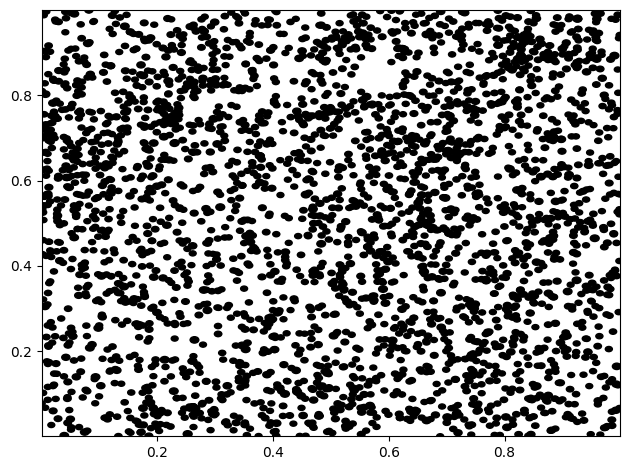

In [ ]:
def plot_exclusion_zones():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(min(ra),max(ra))
    ax.set_ylim(min(dec), max(dec))

    for x, y, r in zip(tractor_df['ra'], tractor_df['dec'], rad):
        c = plt.Circle((x,y), r, color='black')
        ax.add_patch(c)

    plt.tight_layout()
    plt.show()

    return

excl_map = plot_exclusion_zones()


In [8]:
def define_grid(fov=60):
    
    gridlines = np.arange(min(ra), max(ra), (fov/3600))
    return gridlines

gridlines = define_grid()

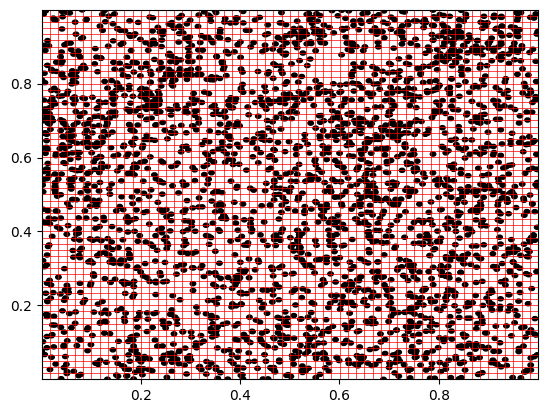

In [9]:
def create_grid():

    # Creating exclusion map with grid
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlim((min(ra),max(ra)))
    ax.set_ylim((min(dec),max(dec)))

    for x, y, r in zip(ra, dec, rad):
        c = plt.Circle((x,y), 0.005556, color='black', fill='false')
        ax.add_patch(c)

    plt.vlines(gridlines, min(dec), max(dec), color='red', linewidth=0.5)
    plt.hlines(gridlines, min(ra), max(ra), color= 'red', linewidth=0.5)
    plt.margins(0)
    plt.show()

    return

create_grid()

In [10]:
def find_dark_regions():

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = gridlines[i], gridlines[i + 1]
            y_start, y_end = gridlines[j], gridlines[j + 1]
            
            if np.all(excl_map[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans

dr_trans = find_dark_regions()

TypeError: 'NoneType' object is not subscriptable